# Comet images

Look at images of cells.

In [ ]:
import datetime
now = datetime.datetime.now()
startNB = now
print("Date and time ",str(now))
#
import numpy as np
import scipy.ndimage as scimg
import matplotlib.pyplot as plt
%matplotlib inline
#
# Read in images
file = '../CometImages/new-val/RGBAtoRGB/Comet012.bmp'
#file = "../CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_000.tif"
#file = "img_000000000_SYBRGreen_000.bmp"
#
imgRaw = plt.imread(file)
print(" ")
print("Image file",file)
print("imgRaw shape",imgRaw.shape)
if len(imgRaw.shape) == 2:
    nRows = imgRaw.shape[0]
    nCols = imgRaw.shape[1]
    img = np.zeros((nRows, nCols))
    img[0: nRows, 0:nCols] = imgRaw[0: nRows, 0:nCols]
elif len(imgRaw.shape) == 3:
    nRows = imgRaw.shape[0]
    nCols = imgRaw.shape[1]
    nDepth = imgRaw.shape[2]
    img = np.zeros((nRows, nCols))
    img[0: nRows, 0:nCols] = imgRaw[0: nRows, 0:nCols, 0]
else:
    print("Raw image has unexpected shape, imgRaw shape =",imgRaw.shape)
    sys.exit()
#
print("Dynamic range",np.amin(img),"to",np.amax(img))
print("Data type",imgRaw.dtype)
fig = plt.figure(figsize=(10, 10))
#
thisplt = fig.add_subplot(1, 1, 1)
plt.title("Picture of " + file)
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
imgplot = plt.imshow(img)
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

In [1]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
import numpy as np
import cv2 
#
def rgba2rgb(rgba, background = (255, 255, 255)):
    '''
    Convert RGBA images to RGB format. Input RGBA image (and background); output RGB image.
    '''
    rows, cols, chans = rgba.shape
    #
    debug = False
    #
    if debug:
        print("------------------------------------------------------------------------------------")
        print("Running rgba2rgb")
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
            return rgba
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 4, 'RGBA image must have 4 channels.'
    #
    rgb = np.zeros((rows, cols, 3), dtype = 'float32')
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]
    #
    a = np.asarray(a, dtype='float32')/255.0
    #
    R, G, B = background
    #
    rgb[:, :, 0] = r*a + (1.0 - a)*R
    rgb[:, :, 1] = g*a + (1.0 - a)*G
    rgb[:, :, 2] = b*a + (1.0 - a)*B
    #
    return np.asarray(rgb, dtype = np.uint8)
#
#
#
def rgb2grey(rgb, negative = 0, withHists = False):
    '''
    Convert RGB image to greyscale. Input RGB (and flag indicating negative required), output greyscale image.
    '''
    rows, cols, chans = rgb.shape
    #
    debugHere = False
    #
    if debugHere:
        print("------------------------------------------------------------------------------------")
        print("Running rgb2grey")
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
        elif chans == 1:
            print("Greyscale image")
            return rgb
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 3, 'RGB image must have 3 channels.'
    #
    grey = np.zeros((rows, cols), dtype = 'float32')
    #
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    #
    grey[:, :] = (0.2125*(r*negative + (negative - 1.0)*r) + 
                  0.7154*(g*negative + (negative - 1.0)*g) + 
                  0.0721*(b*negative + (negative - 1.0)*b))
    if withHists:
        print(" ")
        print("Max intensities red",np.amax(r),"blue",np.amax(b),"green",np.amax(g))
        print(" ")
        nBins = int(256/8)
        nBins = 256
        plt.figure(figsize = (10, 9))
        plt.subplot(4, 1, 1)
        plt.hist(np.ravel(r), bins = nBins, color = 'r')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.subplot(4, 1, 2)
        plt.hist(np.ravel(g), bins = nBins, color = 'g')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.subplot(4, 1, 3)
        plt.hist(np.ravel(b), bins = nBins, color = 'b')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.subplot(4, 1, 4)
        plt.hist(np.ravel(grey), bins = nBins, color = 'k')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.tight_layout()
        plt.show()
    #
    return np.asarray(grey, dtype = np.uint8)
#
#
#
def ceilDiv(a, b):
    '''
    Return a//b rounded up.
    '''
    ceiling = -(-a//b)
    return ceiling
#
#
#
def processRawImage(imgRaw):
    '''
    Convert images of various types to greyscale, removing any hot pixels and rescaling so use full 
    range (0...255) for image without hot pixels 
    '''
    #
    import sys
    import numpy as np
    import scipy.ndimage as ndimage
    import matplotlib.pyplot as plt
    %matplotlib inline
    # 
    # Number of rows and columns. Depth is 3 for RGB, 4 for RGBA image. A is opacity (alpha)
    if len(imgRaw.shape) == 3:
        nRows = imgRaw.shape[0] 
        nCols = imgRaw.shape[1]
        nDepth = imgRaw.shape[2]
    elif len(imgRaw.shape) == 2:
        nRows = imgRaw.shape[0] 
        nCols = imgRaw.shape[1]
        nDepth = 1
    else:
        print("Unexpected image format, imgRaw.shape =",imgRaw.shape)
        sys.exit()
    #
    imgGrey = np.zeros((nRows, nCols))
    #
    # Determine image format and process accordingly
    if nDepth == 4:
        imgRGB = rgba2rgb(imgRaw)
        imgGrey = rgb2grey(imgRGB, 0, withHists)
    elif nDepth == 3:
        imgRGB = imgRaw
        imgGrey = rgb2grey(imgRGB, 1, withHists)
    elif nDepth == 1:
        imgRGB = imgRaw
        imgGrey = imgRaw
    else:
        print(" ")
        print("Unexpected image depth",nDepth)
        sys.stop()
    #
    if imgGrey.dtype == 'uint16':
        imgGreyOut = cv2.convertScaleAbs(imgGrey, alpha = (255.0/65535.0))
    elif imgGrey.dtype == 'uint8':
        imgGreyOut = imgGrey
    else:
        print(" ")
        print("Unknown datatype in image",imgGrey.dtype)
        sys.exit()
    #
    return imgGreyOut, nRows, nCols

def rgbSeperate(rgb, filename, withPlots = True):
    '''
    Seperate RGB image into the R, G, B components and plot image in each of these individual channels.
    '''
    rows, cols, chans = rgb.shape
    #
    debug = False
    #
    if debug:
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
        elif chans == 1:
            print("Greyscale image")
            return rgb
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 3, 'RGB image must have 3 channels.'
    #
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    rMax = np.max(r)
    gMax = np.max(g)
    bMax = np.max(b)
    print("max pixel intensities for the red, green and blue channels are: ", rMax, gMax, bMax)
    #
    if withPlots == True:
        plt.figure(figsize = (12, 9))
        plt.subplot(2, 2, 1)
        plt.title("raw image" + str(filename))
        plt.imshow(rgb, cmap='afmhot')
        plt.subplot(2, 2, 2)
        plt.title("red channel")
        plt.imshow(r, cmap='afmhot')
        plt.subplot(2, 2, 3)
        plt.title("green channel")
        plt.imshow(g, cmap='afmhot')
        plt.subplot(2, 2, 4)
        plt.title("blue channel")
        plt.imshow(b, cmap='afmhot')
        plt.show()
        #
        nBins = 256
        plt.figure(figsize = (12, 9))
        plt.title("intensity histograms for " + str(filename))
        plt.subplot(4, 1, 1)
        plt.hist(imgRGB.flatten(), bins = nBins, color = 'k')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.subplot(4, 1, 2)
        plt.hist(r.flatten(), bins = nBins, color = 'r')
        plt.yscale("log")
        plt.xlim(-1, 256)
        #
        plt.subplot(4, 1, 3)
        plt.hist(g.flatten(), bins = nBins, color = 'g')
        plt.yscale("log")
        plt.xlim(-1, 256)
        #
        plt.subplot(4, 1, 4)
        plt.hist(b.flatten(), bins = nBins, color = 'b')
        plt.yscale("log")
        plt.xlim(-1, 256)
        #

    return r, g, b
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))
#print("Time since notebook start is",str(now - startNB))

Date and time  2022-02-12 19:08:45.034705
 
Date and time 2022-02-12 19:08:45.124840
Time since last check is 0:00:00.090135


In [ ]:
import datetime
import cv2
now = datetime.datetime.now()
print("Date and time ",str(now))
print(" ")
#
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import glob
from PIL import Image
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
%matplotlib inline
#
#
# Check that image looks sensible
imgGrey, nRows, nCols = processRawImage(imgRaw)
print(" ")
print("Dynamic range from",np.amin(imgGrey),"to",np.amax(imgGrey))
print("Type of image file is",imgGrey.dtype)
print("Number of rows",nRows,"of columns",nCols,"of pixels",nRows*nCols)
print("image shape is: ", imgGrey.shape)
pltX = nCols/200
pltY = nRows/200
plt.figure(figsize = (pltX, pltY))
plt.imshow(imgGrey, origin = 'lower', cmap = plt.get_cmap('afmhot'))
cv2.imwrite("4GyB0000.bmp", imgGrey)
plt.show()

#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))
print("Time since noteboook start is",str(now - startNB))

Date and time  2022-02-12 19:22:09.634194
 
Image file ../CometImages/new-train/RGBAtoRGB/0016.bmp
imgRaw shape (1040, 1392, 3)
Dynamic range 0.0 to 254.0
Data type uint8


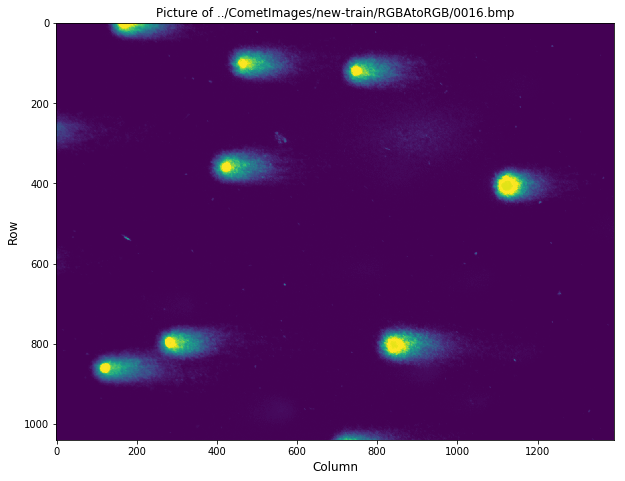

 
Date and time 2022-02-12 19:22:10.020853
Time since last check is 0:00:00.386659


In [16]:
import datetime
now = datetime.datetime.now()
startNB = now
print("Date and time ",str(now))
#
import numpy as np
import scipy.ndimage as scimg
import matplotlib.pyplot as plt
%matplotlib inline
#
# Read in images
file = "../CometImages/new-train/RGBAtoRGB/0016.bmp"
#file = "4GyB0000.bmp"
#file = "img_000000000_SYBRGreen_000.bmp"
#
imgRaw = plt.imread(file)
print(" ")
print("Image file",file)
print("imgRaw shape",imgRaw.shape)
if len(imgRaw.shape) == 2:
    nRows = imgRaw.shape[0]
    nCols = imgRaw.shape[1]
    img = np.zeros((nRows, nCols))
    img[0: nRows, 0:nCols] = imgRaw[0: nRows, 0:nCols]
elif len(imgRaw.shape) == 3:
    nRows = imgRaw.shape[0]
    nCols = imgRaw.shape[1]
    nDepth = imgRaw.shape[2]
    img = np.zeros((nRows, nCols))
    img[0: nRows, 0:nCols] = imgRaw[0: nRows, 0:nCols, 0]
else:
    print("Raw image has unexpected shape, imgRaw shape =",imgRaw.shape)
    sys.exit()
#
print("Dynamic range",np.amin(img),"to",np.amax(img))
print("Data type",imgRaw.dtype)
fig = plt.figure(figsize=(10, 10))
#
thisplt = fig.add_subplot(1, 1, 1)
plt.title("Picture of " + file)
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
imgplot = plt.imshow(img)
plt.show()
#
"""
RGBimage = rgba2rgb(imgRaw)
#cv2.imwrite("../CometImages/new-val/test.bmp", RGBimage)
plt.imsave("../CometImages/new-val/test.bmp", RGBimage)
plt.imshow(RGBimage)
plt.show()
print("shape of RGB image is: ", RGBimage.shape)
"""
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## inspect images to see shape - if RGBA need to convert to RGB for training


Date and time  2022-02-12 19:20:55.101939
 
files to process are:  ['0002.bmp', '0004.bmp', '0005.bmp', '0010.bmp', '0011.bmp', '0016.bmp', '0018.bmp', '0019.bmp', '4Gy 0h-3irrad.bmp', '4Gy 0h-4irrad.bmp', '4Gy 0hirrad.bmp', '4Gy 1h-2irrad.bmp', '4Gy 1h-3irrad.bmp', '4Gy 2h-3irrad.bmp', '4GyA001.bmp', '4GyA0016.bmp', '4GyA0018.bmp', '4GyA0019.bmp', '4GyA0024.bmp', '4GyA0025.bmp', '4GyA0027.bmp', '4GyA004.bmp', '4GyA007.bmp', '4GyA009.bmp', '4GyB000.bmp', '4GyB0011.bmp', '4GyB0012.bmp', '4GyB0018.bmp', '4GyB0021.bmp', '4GyB0027.bmp', '4GyB0028.bmp', '4GyB003.bmp', '4GyB006.bmp', '4GyB007.bmp', '4GyC001.bmp', '4GyC0012.bmp', '4GyC0014.bmp', '4GyC0019.bmp', '4GyC002.bmp', '4GyC0025.bmp', '4GyC0026.bmp', '4GyC0032.bmp', '4GyC0034.bmp', '4GyC004.bmp', 'Comet001.bmp', 'Comet002.bmp', 'Comet003.bmp', 'Comet007.bmp', 'Comet008.bmp', 'Comet010.bmp', 'Comet013.bmp', 'Comet014.bmp', 'Comet015.bmp', 'Comet016.bmp', 'Comet019.bmp', 'Comet03.bmp', 'Comet04.bmp', 'Comet05.bmp', 'Comet08.bmp', 'Comet0

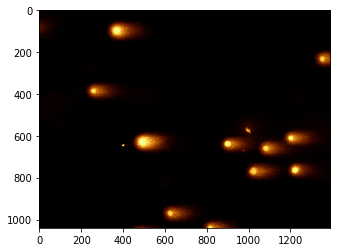

image shape is:  (1040, 1392, 4)

Raw image


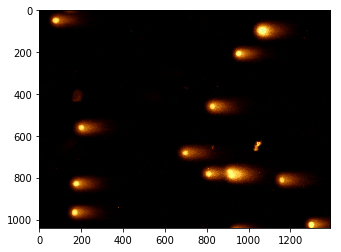

image shape is:  (1040, 1392, 4)

Raw image


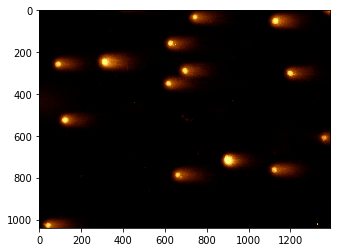

image shape is:  (1040, 1392, 4)

Raw image


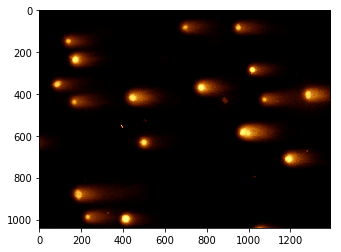

image shape is:  (1040, 1392, 4)

Raw image


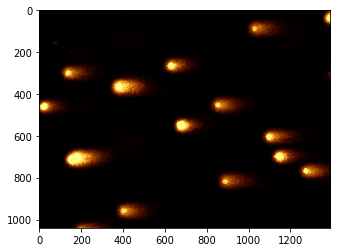

image shape is:  (1040, 1392, 4)

Raw image


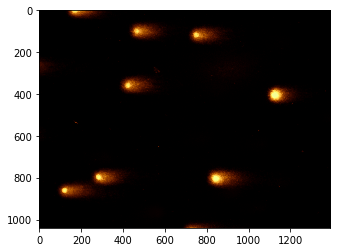

image shape is:  (1040, 1392, 4)

Raw image


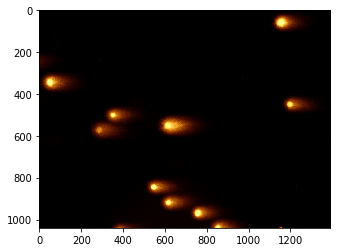

image shape is:  (1040, 1392, 4)

Raw image


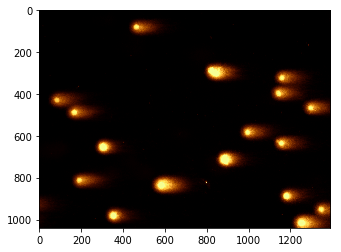

image shape is:  (1040, 1392, 4)

Raw image


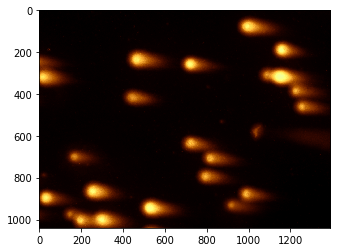

image shape is:  (1040, 1392, 4)

Raw image


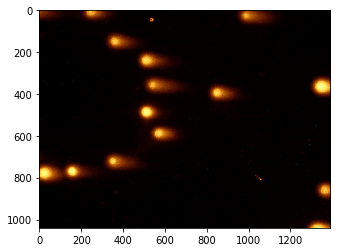

image shape is:  (1040, 1392, 4)

Raw image


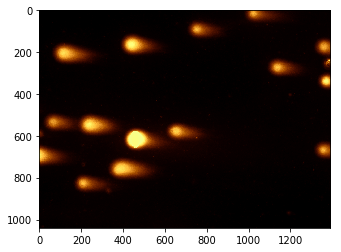

image shape is:  (1040, 1392, 4)

Raw image


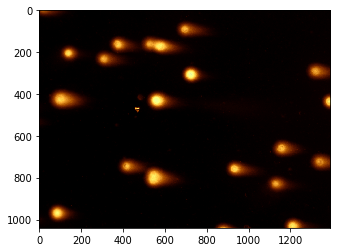

image shape is:  (1040, 1392, 4)

Raw image


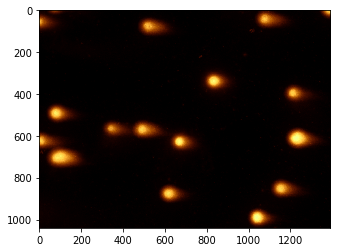

image shape is:  (1040, 1392, 4)

Raw image


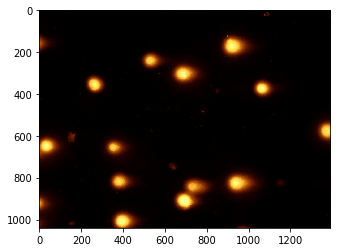

image shape is:  (2048, 2048, 3)

Raw image


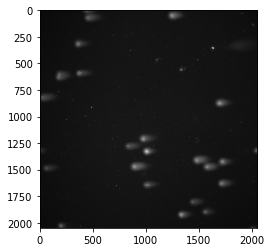

image shape is:  (2048, 2048, 3)

Raw image


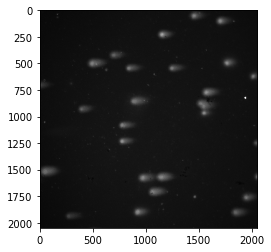

image shape is:  (2048, 2048, 3)

Raw image


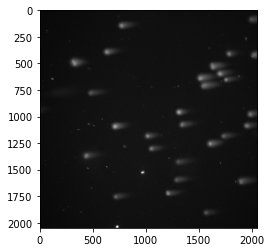

image shape is:  (2048, 2048, 3)

Raw image


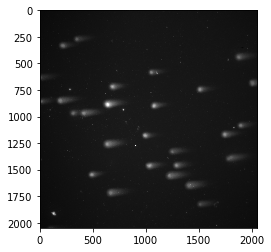

image shape is:  (2048, 2048, 3)

Raw image


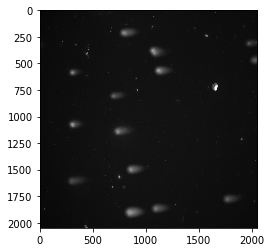

image shape is:  (2048, 2048, 3)

Raw image


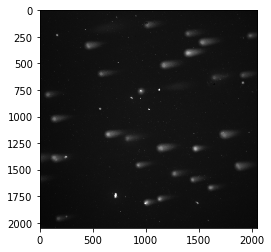

image shape is:  (2048, 2048, 3)

Raw image


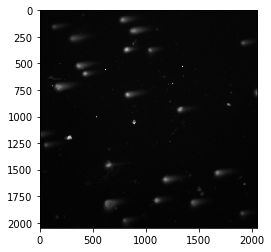

image shape is:  (2048, 2048, 3)

Raw image


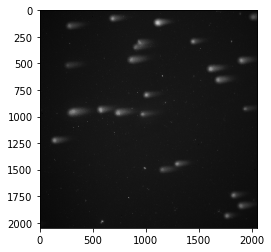

image shape is:  (2048, 2048, 3)

Raw image


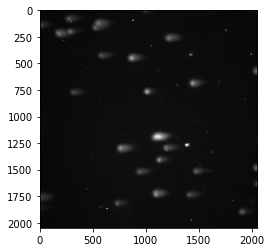

image shape is:  (2048, 2048, 3)

Raw image


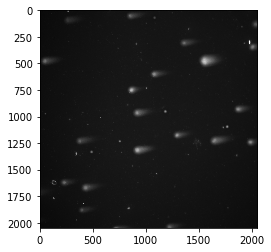

image shape is:  (2048, 2048, 3)

Raw image


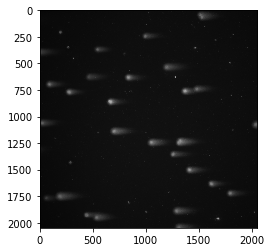

image shape is:  (2048, 2048, 3)

Raw image


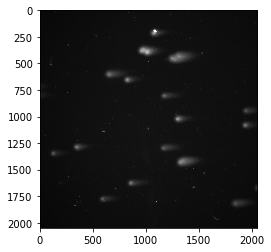

image shape is:  (2048, 2048, 3)

Raw image


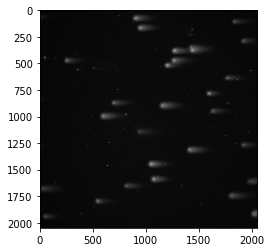

image shape is:  (2048, 2048, 3)

Raw image


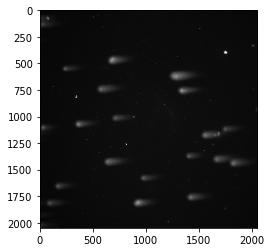

image shape is:  (2048, 2048, 3)

Raw image


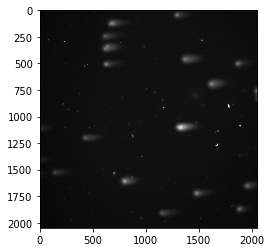

image shape is:  (2048, 2048, 3)

Raw image


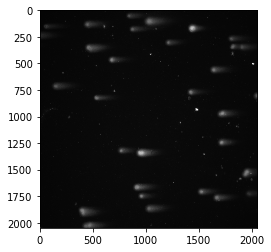

image shape is:  (2048, 2048, 3)

Raw image


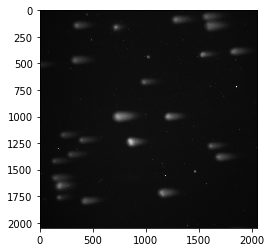

image shape is:  (2048, 2048, 3)

Raw image


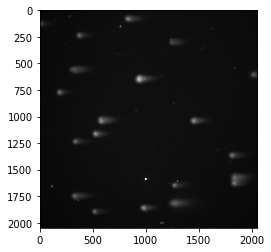

image shape is:  (2048, 2048, 3)

Raw image


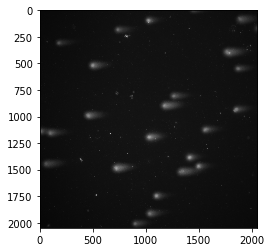

image shape is:  (2048, 2048, 3)

Raw image


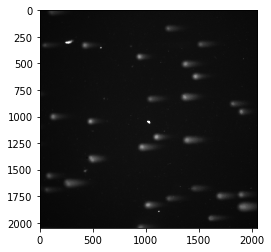

image shape is:  (2048, 2048, 3)

Raw image


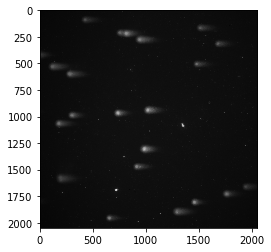

image shape is:  (2048, 2048, 3)

Raw image


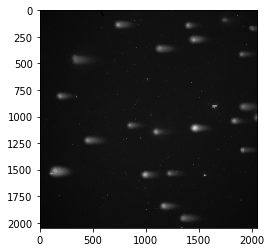

image shape is:  (2048, 2048, 3)

Raw image


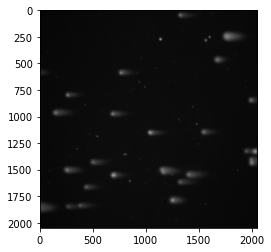

image shape is:  (2048, 2048, 3)

Raw image


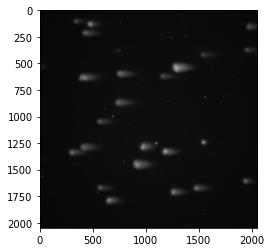

image shape is:  (2048, 2048, 3)

Raw image


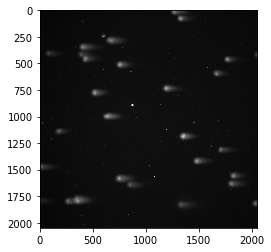

image shape is:  (2048, 2048, 3)

Raw image


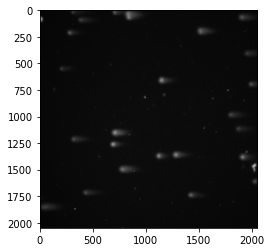

image shape is:  (2048, 2048, 3)

Raw image


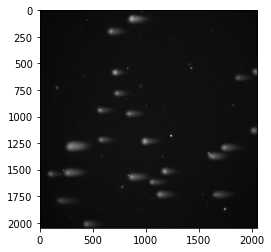

image shape is:  (2048, 2048, 3)

Raw image


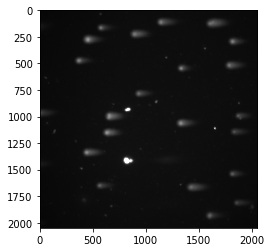

image shape is:  (2048, 2048, 3)

Raw image


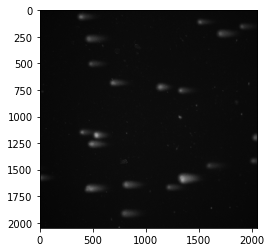

image shape is:  (2048, 2048, 3)

Raw image


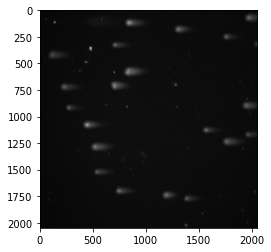

image shape is:  (1040, 1392, 4)

Raw image


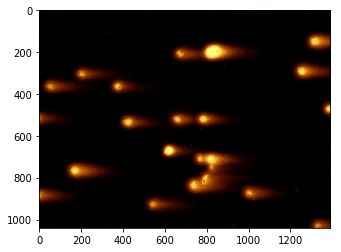

image shape is:  (1040, 1392, 4)

Raw image


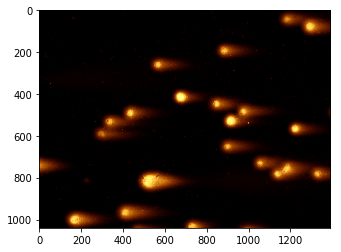

image shape is:  (1040, 1392, 4)

Raw image


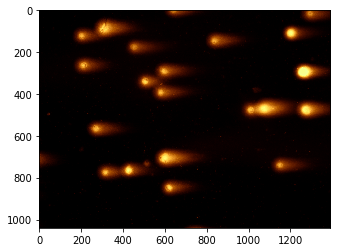

image shape is:  (1040, 1392, 4)

Raw image


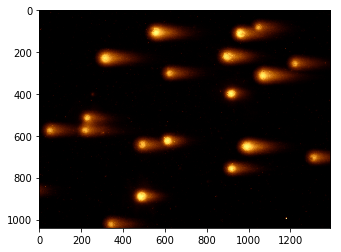

image shape is:  (1040, 1392, 4)

Raw image


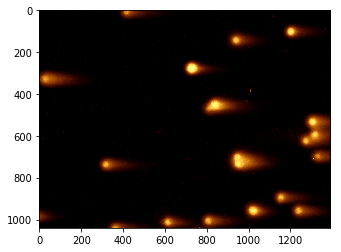

image shape is:  (1040, 1392, 4)

Raw image


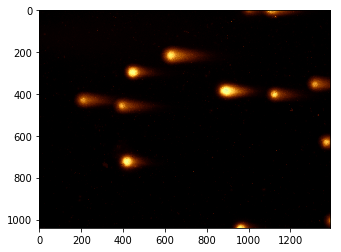

image shape is:  (1040, 1392, 4)

Raw image


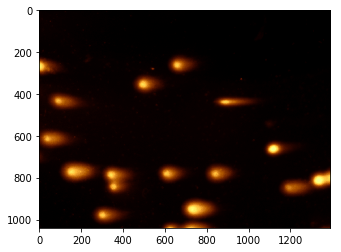

image shape is:  (1040, 1392, 4)

Raw image


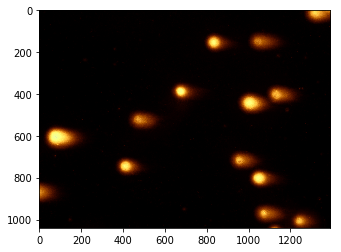

image shape is:  (1040, 1392, 4)

Raw image


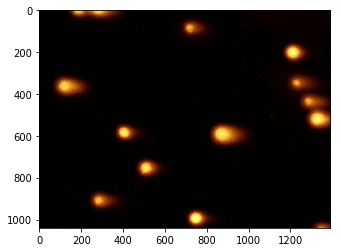

image shape is:  (1040, 1392, 4)

Raw image


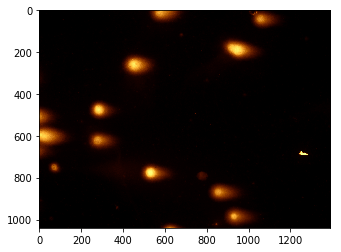

image shape is:  (1040, 1392, 4)

Raw image


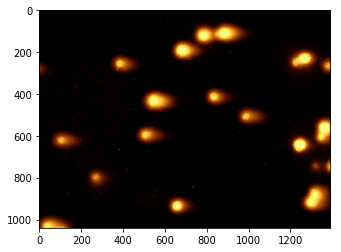

image shape is:  (1040, 1392, 4)

Raw image


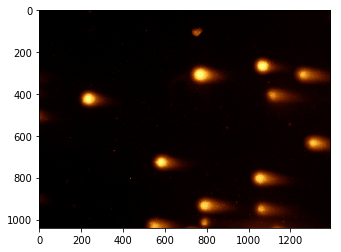

image shape is:  (1040, 1392, 4)

Raw image


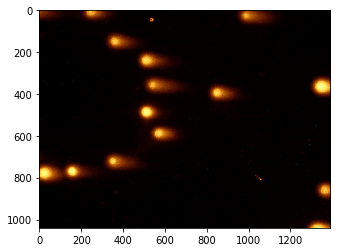

image shape is:  (1040, 1392, 4)

Raw image


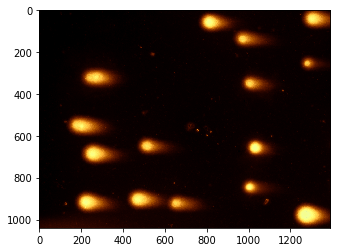

image shape is:  (1040, 1392, 4)

Raw image


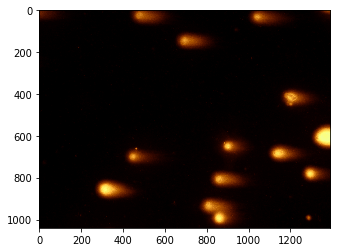

image shape is:  (1040, 1392, 4)

Raw image


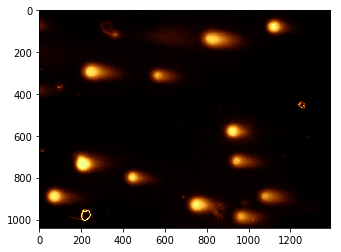

 
Date and time 2022-02-12 19:21:22.918124
Time since last check is 0:00:27.816185


In [13]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
print(" ")
#
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
from skimage.io import imsave

im_dir = '../CometImages/new-train/*.bmp'
fileList= sorted(glob.glob(im_dir))  #whole file path, as set in above line
fileNames = [os.path.basename(x) for x in sorted(glob.glob(im_dir))]  #only file name with extension - no [0] at end if multi files
print("files to process are: ", fileNames)
nFiles =  len(fileNames)
print("fileNames length is: ", len(fileNames))
#
fileNamesSplit = np.empty((nFiles), dtype = 'object')
for n in range (0, nFiles):
    x = fileNames[n]
    fileNamesSplit[n] = os.path.splitext(x)[0]   #remove extension from file name

print("fileNamesSplit is: ", fileNamesSplit)
fileNames = np.array(fileNames)
print("shape of file split is: ", fileNamesSplit.shape)
#
out_dir = '../CometImages/new-train/RGBAtoRGB/'
RGBAlist = []
for nF in range (nFiles):
    imgRaw = plt.imread(fileList[nF])
    shape = imgRaw.shape
    print("image shape is: ", shape)
    print("\nRaw image")
    plt.imshow(imgRaw)
    plt.show()
    #   
    nRows = imgRaw.shape[0] # y coordinates
    nCols = imgRaw.shape[1] # x ccordinates
    #
    if len(shape) == 3:
        nDepth = imgRaw.shape[2]
    else:
        nDepth = 1

    # Determine image format and process accordingly
    if nDepth == 4:
        imgRGB = rgba2rgb(imgRaw)
        RGBAlist.append(fileNames[nF])
        #cv2.imwrite(out_dir + str(fileNames[nF]), RGB)
        #plt.imsave(out_dir + str(fileNames[nF]), imgRGB)
        imsave(out_dir + str(fileNames[nF]), imgRGB)
        imgGrey = rgb2grey(imgRGB, 1)
    elif nDepth == 3:
        imgRGB = imgRaw
        imgGrey = rgb2grey(imgRGB, 1)
    elif nDepth == 1:
        imgRGB = imgRaw
        imgGrey = imgRaw
    else:
        print(" ")
        print("Unexpected image depth",nDepth)
        sys.stop()
    #
#print("length of RGBAlist is: ", len(RGBAlist))
#print("RGBAlist is: ", RGBAlist)
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

### Check R, G, B channels as not sure conversion is correct

In [ ]:
def convert2RGBsave(imgRGB, :
    r, g, b = imgRGB[:,:,0], imgRGB[:,:,1], imgRGB[:,:,2]
    nBins = 256
    plt.figure(figsize = (12, 9))
    plt.title("intensity histograms for " + str(filename))
    plt.subplot(4, 1, 1)
    plt.hist(imgRGB.flatten(), bins = nBins, color = 'k')
    plt.yscale("log")
    plt.xlim(-1, 256)
    #
    plt.subplot(4, 1, 2)
    plt.hist(r.flatten(), bins = nBins, color = 'r')
    plt.yscale("log")
    plt.xlim(-1, 256)
    #
    plt.subplot(4, 1, 3)
    plt.hist(g.flatten(), bins = nBins, color = 'g')
    plt.yscale("log")
    plt.xlim(-1, 256)
    #
    plt.subplot(4, 1, 4)
    plt.hist(b.flatten(), bins = nBins, color = 'b')
    plt.yscale("log")
    plt.xlim(-1, 256)
    plt.show()
    RG = np.dstack((r, g))
    RGB = np.dstack((RG, b))
    print("shape of converted RGB image is: ", RGB.shape)